In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
(X_Train,_),(_,_) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*(X_Train.shape),1))
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [4]:
#Normalize the Data between -1 and 1

X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [5]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)

NOISE_DIM = 100

from keras.optimizers import legacy as optimizers

adam = optimizers.Adam(lr=2e-4, beta_1=0.5)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
#Upsampling
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double the Activation Size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)       

In [8]:
#Discriminator - Downsampling
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [10]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)

model.compile(loss='binary_crossentropy',optimizer=adam)

def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)

    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()



In [11]:
!mkdir images

In [ ]:
X_Train.shape

(60000, 28, 28, 1)

4/4 [==============================] - 0s 3ms/step
Epoch 1 D loss: 124.851760 G loss: 149.999830
4/4 [==============================] - 0s 3ms/step
Epoch 2 D loss: 180.166572 G loss: 204.929193
4/4 [==============================] - 0s 3ms/step
Epoch 3 D loss: 167.215926 G loss: 207.999471
4/4 [==============================] - 0s 3ms/step
Epoch 4 D loss: 165.595665 G loss: 199.669850
4/4 [==============================] - 0s 4ms/step
Epoch 5 D loss: 165.728695 G loss: 196.111898
4/4 [==============================] - 0s 4ms/step
Epoch 6 D loss: 164.796618 G loss: 194.531003
4/4 [==============================] - 0s 3ms/step
Epoch 7 D loss: 163.970601 G loss: 194.092261
4/4 [==============================] - 0s 6ms/step
Epoch 8 D loss: 163.400615 G loss: 194.227281
4/4 [==============================] - 0s 3ms/step
Epoch 9 D loss: 163.074435 G loss: 193.183891
4/4 [==============================] - 0s 3ms/step
Epoch 10 D loss: 162.716289 G loss: 193.511077


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 56ms/step


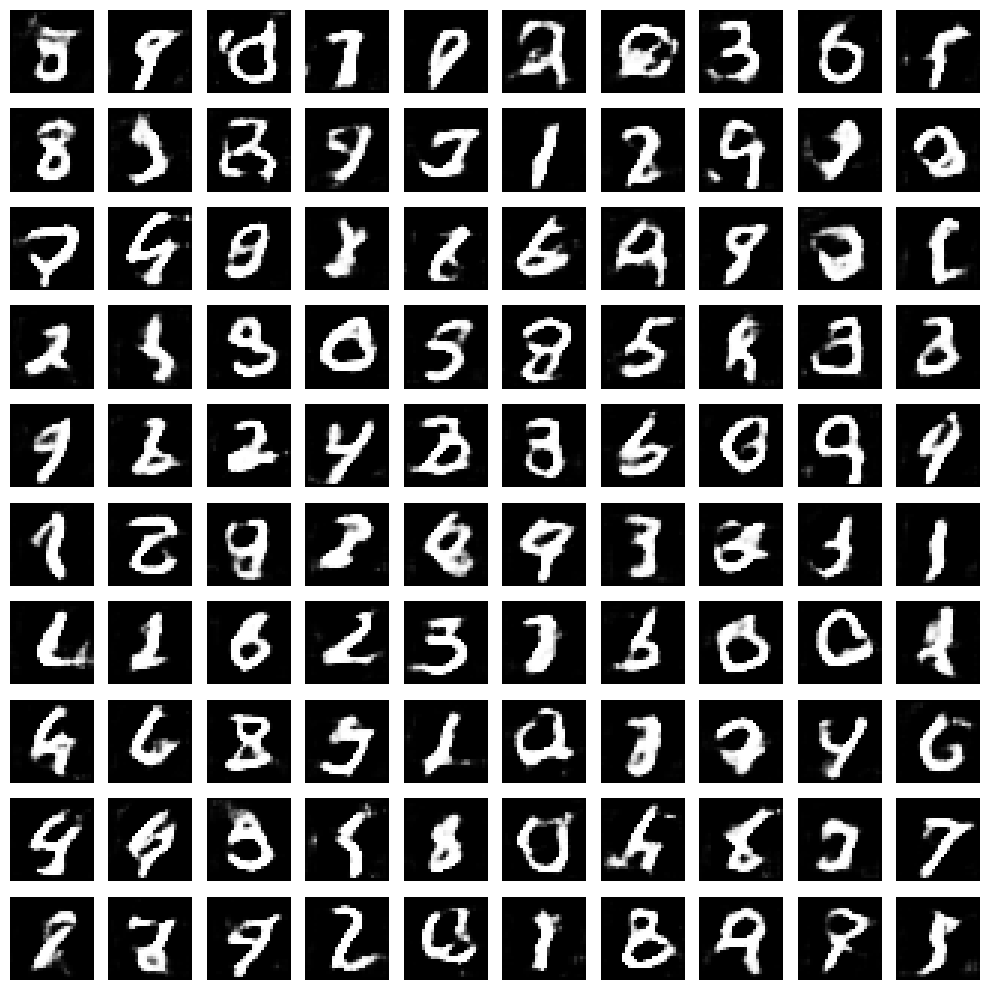

4/4 [==============================] - 0s 6ms/step
Epoch 11 D loss: 162.378842 G loss: 193.504144
4/4 [==============================] - 0s 4ms/step
Epoch 12 D loss: 162.120508 G loss: 194.238128
4/4 [==============================] - 0s 3ms/step
Epoch 13 D loss: 161.918562 G loss: 194.123796
4/4 [==============================] - 0s 3ms/step
Epoch 14 D loss: 161.831981 G loss: 193.820990
4/4 [==============================] - 0s 4ms/step
Epoch 15 D loss: 161.742537 G loss: 192.787718
1/4 [======>.......................] - ETA: 0s

In [ ]:
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.

    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]

        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_imgs = generator.predict(noise)


        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))

        # train on real and fake images

        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

        epoch_d_loss += d_loss


        #Train Generator (Complete Model Generator + Frozen Discriminator)

        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,real_y)
        epoch_g_loss += g_loss

    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    if (epoch+1)%10==0:
        generator.save('models/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)




In [ ]:
!ls

sample_data


In [ ]:
!zip -r /content/models.zip /content/models

	zip warning: name not matched: /content/models

zip error: Nothing to do! (try: zip -r /content/models.zip . -i /content/models)


In [ ]:
from google.colab import files
files.download("/content/models.zip")

FileNotFoundError: Cannot find file: /content/models.zip

In [ ]:
save_imgs(50)